# Neural Net Using Pytorch and DVC
This model uses Pytorch to create a multi-layered neural network with a sigmoid activation function.

### Neural Net Definition

In [289]:
from torch import nn, optim, Tensor, FloatTensor, float32

#
# Neural network for learning boolean operations
#
class NeuralNet(nn.Module):
    def __init__(self) -> None:
        """Init NeuralNet with 2 inputs, 1 hidden layer with 4 nodes, and 2 outputs"""
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 4, dtype=float32),
            nn.Sigmoid(),
            nn.Linear(4, 2, dtype=float32)
        )

    def forward(self, x) -> Tensor:
        """Propagate values through layer in network"""
        logits = self.layers(x)
        probs = nn.Softmax(-1)(logits)
        return probs

In [290]:
_model = NeuralNet()
print(_model)

NeuralNet(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=4, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=4, out_features=2, bias=True)
  )
)


### Util Class for Boolean Operations Dataset

In [291]:
import numpy as np
import operator

def get_pair(operator) -> tuple[Tensor, Tensor]:
    """Generate a set of inputs and correct output for model"""
    values = np.random.choice([1, 0], 2)            # Two random inputs
    answer = [int(operator(values[0], values[1]))]  # Get correct output
    answer += [int(not answer[0])]
    return Tensor(values).type(float32), Tensor(answer).type(float32)

### Util Functions for Training/Validating

In [292]:
import torch

loss_fn = nn.MSELoss()
optimizer = optim.SGD(_model.parameters(), lr=0.018)

def train(operator, batches, batch_size=5, model=_model) -> float:
    loss_hist = []
    for batch in range(batches):
        pairs, labels = [], []
        for _ in range(batch_size):
            pair, label = get_pair(operator)
            pairs.append(pair)
            labels.append(label)

        data = torch.stack(pairs)
        true = torch.stack(labels)

        pred: Tensor = model(data)
        loss: Tensor = loss_fn(pred, true)
        loss_hist.append(loss.detach().numpy())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    return np.array(loss_hist).mean()


In [293]:
def validate(operator, model=_model) -> dict:
    """Validate the test neural network"""
    # Generate validation set
    values: list[list[int]] = []
    for val_1 in range(2):
        for val_2 in range(2):
            values.append([val_1, val_2])

    # Run network on validation set
    for it, inputs in enumerate(values):
        with torch.no_grad():
            preds = model(Tensor(inputs))
        label = [int(operator(inputs[0], inputs[1]))]
        label += [int(not label[0])]
        return {
            "inputs": inputs,
            "preds": preds,
            "labels": label,
        }

### Train and Evaluate Model

# DVC Report

metrics.json

|   train.avg_loss |   step |
|------------------|--------|
|        0.0406892 |     99 |

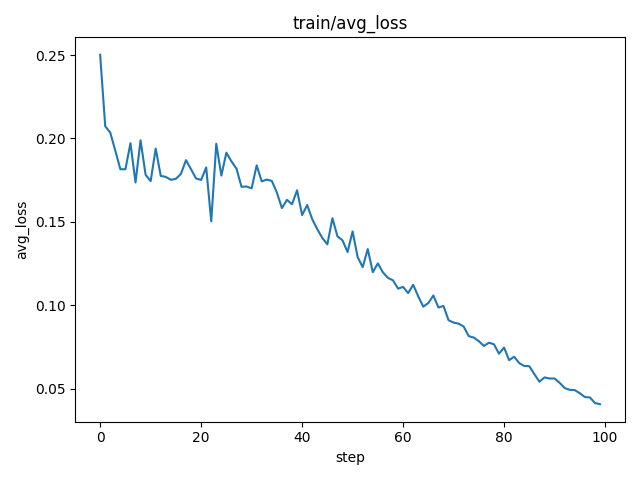



In [294]:
from dvclive import Live
op = operator.and_
epochs = 100
with Live(report='notebook', save_dvc_exp=False) as live:
    for epoch in range(epochs):
        avg_loss = train(op, 100)
        live.log_metric('train/avg_loss', avg_loss)
        metrics = validate(op)
        live.log_sklearn_plot('confusion_matrix', metrics['labels'], metrics['preds'], 'valid/metrics')
        live.next_step()